# CMGP: Train and Evaluation

This notebook presents the solution for training and evaluating the __CMGP__ algorithm over the [Twins](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/data/twins/) dataset..

The implementation of CMGP is adapted in the local `ite` library. For the Unified API version, check [this notebook](https://github.com/bcebere/ite-api/blob/main/notebooks/unified_api_train_evaluation.ipynb).

## Causal Multi-task Gaussian Processes(CMGP)

Estimating Individualized Treatment Effects(__ITE__) is the task that approximates whether a given treatment influences or determines an outcome([read more](https://www.vanderschaar-lab.com/individualized-treatment-effect-inference/)).

[__CMGP__](https://arxiv.org/pdf/1704.02801.pdf) is a nonparametric Bayesian method for learning the treatment effects using a multi-task Gaussian process (GP) with a linear coregionalization kernel as
a prior over the vector-valued reproducing kernel Hilbert space(vvRKHS).

The implementation demonstrated in this notebook is [here](https://github.com/bcebere/ite-api/tree/main/src/ite/algs/causal_multitask_gaussian_processes) and is adapted from [this implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/causal_multitask_gaussian_processes_ite/).

## Setup

First, make sure that all the depends are installed in the current environment.
```
pip install -r requirements.txt
pip install .
```

Next, we import all the dependencies necessary for the task.

In [1]:
# Double check that we are using the correct interpreter.
import sys
print(sys.executable)
    
# Import depends
import ite.algs.causal_multitask_gaussian_processes.model as alg
import ite.datasets as ds
import ite.utils.numpy as utils
import numpy as np

from matplotlib import pyplot as plt

/home/bcebere/anaconda3/envs/cambridge/bin/python
Instructions for updating:
non-resource variables are not supported in the long term


## Load the Dataset

The example is done using the [Twins](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/data/twins/) dataset.

Next, we load the dataset, process the data, and sample a training set and a test set.

The logic is implemented [here](https://github.com/bcebere/ite-api/tree/main/src/ite/datasets), and it adapted from the original [GANITE pre-processing implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/ganite/data_preprocessing_ganite.py).


__Important__: For CGMP, we have to downsample the dataset to 1000 training items.

In [2]:
train_ratio = 0.8
 
dataset = ds.load("twins", train_ratio, downsample=1000)
[Train_X, Train_T, Train_Y, Opt_Train_Y, Test_X, Test_Y] = dataset

## Load the model

Next, we define the model.


The constructor supports the following parameters:
 - `dim`: The number of features in X.
 - `dim_outcome`: The number of potential outcomes.
 - `max_gp_iterations`: Maximum number of GP iterations before stopping the training.

In [3]:
dim = len(Train_X[0])
dim_outcome = Test_Y.shape[1]
        
model = alg.CMGP(
    dim=dim,
    dim_outcome=dim_outcome,
    max_gp_iterations=500,
)

assert model is not None

## Run experiments

In [4]:
for experiment in range(6):
    dataset = ds.load(
        "twins",
        train_ratio,
        downsample=1000,
    )
 
    metrics = model.train(*dataset)

 /home/bcebere/anaconda3/envs/cambridge/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /home/bcebere/anaconda3/envs/cambridge/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /home/bcebere/anaconda3/envs/cambridge/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /home/bcebere/anaconda3/envs/cambridge/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide


## Plot experiments metrics

in-sample metrics:
 - sqrt_PEHE: 0.289 +/- 0.008
 - ATE: 0.007 +/- 0.009
 - MSE: 0.073 +/- 0.003
out-sample metrics:
 - sqrt_PEHE: 0.286 +/- 0.022
 - ATE: 0.011 +/- 0.006
 - MSE: 0.011 +/- 0.006


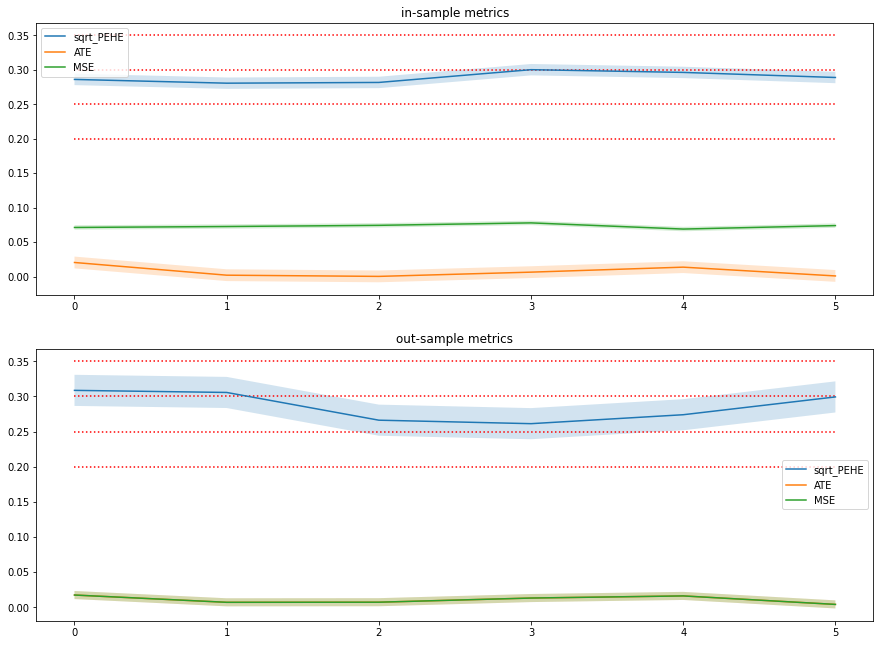

In [5]:
metrics.print()

metrics.plot(plt, with_ci=True, thresholds=[0.2, 0.25, 0.3, 0.35])

## Predict

In [6]:
hat_y = model.predict(Test_X)
utils.sqrt_PEHE(hat_y.to_numpy(), Test_Y)

0.3075605582649002

## Test
Will can run inferences and get metrics directly

In [7]:
metrics = model.test(Test_X, Test_Y)
 
metrics.print()

sqrt_PHE = 0.308
ATE = 0.009
MSE = 0.076
Top 5 worst mistakes(indices) = [157 484 435 962 710]


## References

1. Ahmed M. Alaa, Mihaela van der Schaar, "Bayesian Inference of Individualized Treatment
Effects using Multi-task Gaussian Processes", NeurIPS, 2017 ([Paper](https://arxiv.org/pdf/1704.02801.pdf)).
2. [CMGP Reference implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/causal_multitask_gaussian_processes_ite/).